In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, mean_squared_error, root_mean_squared_error, classification_report, f1_score, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
import pandas as pd
import numpy as np
import re
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree, plot_importance
import time
import random
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
from hyperopt import hp, Trials
from scipy import stats

/lustre/scratch125/casm/team215mg/pg21_rotation/software/miniforge3/envs/xgboost/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preliminary random forests

Initial random forests when they first moved from binary predictions into multi-label predictions. This code goes through all generated replicates of CellDrift, converts it into a format that is readable for RF, then creates a model in a CV loop. A few trees are also generated as an example of what they might look like. The model is tested against all observations from 72 hours, the result is very mediocre performance which is likely due to overfitting as can be seen by tree depth.

In [15]:
coefficients = pd.DataFrame()

for rep in range(1,11):
    temp_coeff_24 = pd.read_csv(f'/lustre/scratch125/casm/team215mg/pg21_rotation/Coefficients_CellDrift/selection_rep_{rep}/Contrast_Coefficients_time_24.txt', sep = '\t')
    temp_coeff_24['contrast'] = temp_coeff_24['contrast'] + f'_{rep}'
    temp_coeff_24['time'] = '24'
    temp_coeff_72 = pd.read_csv(f'/lustre/scratch125/casm/team215mg/pg21_rotation/Coefficients_CellDrift/selection_rep_{rep}/Contrast_Coefficients_time_72.txt', sep = '\t')
    temp_coeff_72['contrast'] = temp_coeff_72['contrast'] + f'_{rep}'
    temp_coeff_72['time'] = '72'
    coefficients = pd.concat([coefficients, temp_coeff_24, temp_coeff_72], ignore_index = True)

coefficients['cell_type'] = coefficients['cell_type'].str.split(',', n = 1).str.get(-1).str.split("'").str.get(-2)
coefficients['perturbation'] = coefficients['perturbation'].str.split(',', n = 1).str.get(0).str.split("'").str.get(-2)
coefficients['cell_type'] = coefficients['cell_type'].map({'Fetal':0, 'Stem':1, 'Cycling':2, 'Secretory':3, 'Stress':4, 'Respiration':5})

coefficients = coefficients[coefficients['p_fdr'] < 0.05]
coefficients = coefficients[(coefficients['perturbation'] == 'MRTX1133_SHP099') | (coefficients['perturbation'] == 'MRTX1133_afatinib')]

coefficients

,contrast,cell_type,perturbation,mean,lci,uci,SE,z,p,p_fdr,pts_contrast,pts_reference,gene,time
1,Cycling_MRTX1133_SHP099-Cycling_DMSO_1,2,MRTX1133_SHP099,1.0593,1.7051,0.4136,0.3295,3.2152,0.0013,0.007800,0.219178,0.123333,ABAT,24
2,Cycling_MRTX1133_afatinib-Cycling_DMSO_1,2,MRTX1133_afatinib,1.0974,1.8266,0.3682,0.3721,2.9495,0.0032,0.016258,0.200000,0.123333,ABAT,24
6,Fetal_MRTX1133_SHP099-Fetal_DMSO_1,0,MRTX1133_SHP099,-0.6763,-0.2199,-1.1328,0.2329,-2.9040,0.0037,0.017794,0.350000,0.360000,ABAT,24
12,Stem_MRTX1133_afatinib-Stem_DMSO_1,1,MRTX1133_afatinib,0.5909,1.0459,0.1360,0.2321,2.5460,0.0109,0.040875,0.240000,0.213333,ABAT,24
21,Secretory_MRTX1133_SHP099-Secretory_DMSO_1,3,MRTX1133_SHP099,1.1338,1.7421,0.5256,0.3103,3.6536,0.0003,0.002821,0.330000,0.193333,ABAT,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488907,Stress_MRTX1133_afatinib-Stress_DMSO_10,4,MRTX1133_afatinib,0.7520,1.1432,0.3608,0.1996,3.7678,0.0002,0.001167,0.410000,0.316667,ZNF608,72
488921,Stem_MRTX1133_SHP099-Stem_DMSO_10,1,MRTX1133_SHP099,0.9310,1.5766,0.2854,0.3294,2.8264,0.0047,0.016269,0.210000,0.186667,ZNF704,72
488922,Stem_MRTX1133_afatinib-Stem_DMSO_10,1,MRTX1133_afatinib,1.1982,1.8086,0.5878,0.3114,3.8475,0.0001,0.000630,0.200000,0.186667,ZNF704,72
488936,Stress_MRTX1133_SHP099-Stress_DMSO_10,4,MRTX1133_SHP099,0.9426,1.5070,0.3782,0.2880,3.2734,0.0011,0.004779,0.160000,0.126667,ZNF704,72


In [16]:
pivot = coefficients.pivot_table('z', ['contrast', 'cell_type', 'time'], 'gene').fillna(0)
pivot.reset_index(drop = False, inplace = True)
pivot

gene,contrast,cell_type,time,ABAT,ABCA1,ABCA12,ABCB1,ABHD2,ABHD6,ABTB2,...,Z93403_1,ZBTB10,ZBTB20,ZBTB7C,ZFPM2,ZHX2,ZNF165,ZNF608,ZNF704,ZNF831
0,Cycling_MRTX1133_SHP099-Cycling_DMSO_1,2,24,3.2152,3.1070,0.0000,0.0000,0.0000,0.0,0.0000,...,2.9409,2.6872,2.8995,0.0,0.0,0.0,0.0000,0.0000,5.5932,0.0
1,Cycling_MRTX1133_SHP099-Cycling_DMSO_1,2,72,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,2.8306,...,5.4727,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,2.9951,0.0
2,Cycling_MRTX1133_SHP099-Cycling_DMSO_10,2,24,3.4190,3.6973,0.0000,0.0000,0.0000,0.0,0.0000,...,0.0000,3.6377,2.8241,0.0,0.0,0.0,0.0000,0.0000,5.1164,0.0
3,Cycling_MRTX1133_SHP099-Cycling_DMSO_10,2,72,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,...,4.7586,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0
4,Cycling_MRTX1133_SHP099-Cycling_DMSO_2,2,24,2.9620,3.8301,0.0000,0.0000,0.0000,0.0,0.0000,...,0.0000,4.1826,2.3463,0.0,0.0,0.0,0.0000,0.0000,5.5870,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,Stress_MRTX1133_afatinib-Stress_DMSO_7,4,72,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,3.2044,...,5.9082,0.0000,0.0000,0.0,0.0,0.0,3.1232,4.0589,0.0000,0.0
236,Stress_MRTX1133_afatinib-Stress_DMSO_8,4,24,0.0000,5.2278,3.5740,0.0000,0.0000,0.0,0.0000,...,3.2075,5.3845,0.0000,0.0,0.0,0.0,0.0000,2.4730,0.0000,0.0
237,Stress_MRTX1133_afatinib-Stress_DMSO_8,4,72,0.0000,0.0000,0.0000,2.8247,-3.0268,0.0,2.5396,...,5.9887,0.0000,0.0000,0.0,0.0,0.0,0.0000,2.8822,0.0000,0.0
238,Stress_MRTX1133_afatinib-Stress_DMSO_9,4,24,0.0000,3.3562,0.0000,0.0000,0.0000,0.0,0.0000,...,0.0000,4.7772,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0


In [17]:
pivot_24 = pivot[pivot['time'] == '24']
pivot_72 = pivot[pivot['time'] == '72']
y_24 = pivot_24['cell_type'].to_numpy()
y_72 = pivot_72['cell_type'].to_numpy()

In [18]:
pivot_24.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_24 = pivot_24.to_numpy()
pivot_72.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_72 = pivot_72.to_numpy()
X_72

/tmp/ipykernel_911645/3686452598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_24.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)
/tmp/ipykernel_911645/3686452598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_72.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)


array([[0.    , 0.    , 0.    , ..., 0.    , 2.9951, 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 2.1785, 0.    , ..., 2.5719, 2.9581, 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 4.0589, 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 2.8822, 0.    , 0.    ],
       [0.    , 0.    , 3.3197, ..., 4.0569, 0.    , 0.    ]],
      shape=(120, 649))

In [19]:
X_24_train, X_24_test, y_24_train, y_24_test = train_test_split(X_24, y_24, test_size = 0.2)
X_72_train, X_72_test, y_72_train, y_72_test = train_test_split(X_72, y_72, test_size = 0.2)

In [8]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=20, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_24_train, y_24_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14a92fe39f90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14a92fdffb60>})

In [9]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 84}


In [10]:
y_pred = best_rf.predict(X_24_test)
accuracy = accuracy_score(y_24_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


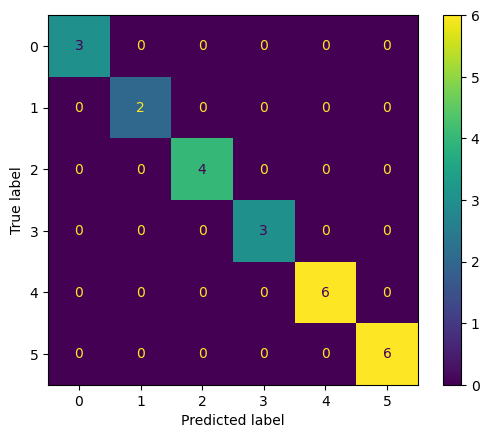

In [11]:
# Create the confusion matrix
cm = confusion_matrix(y_24_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

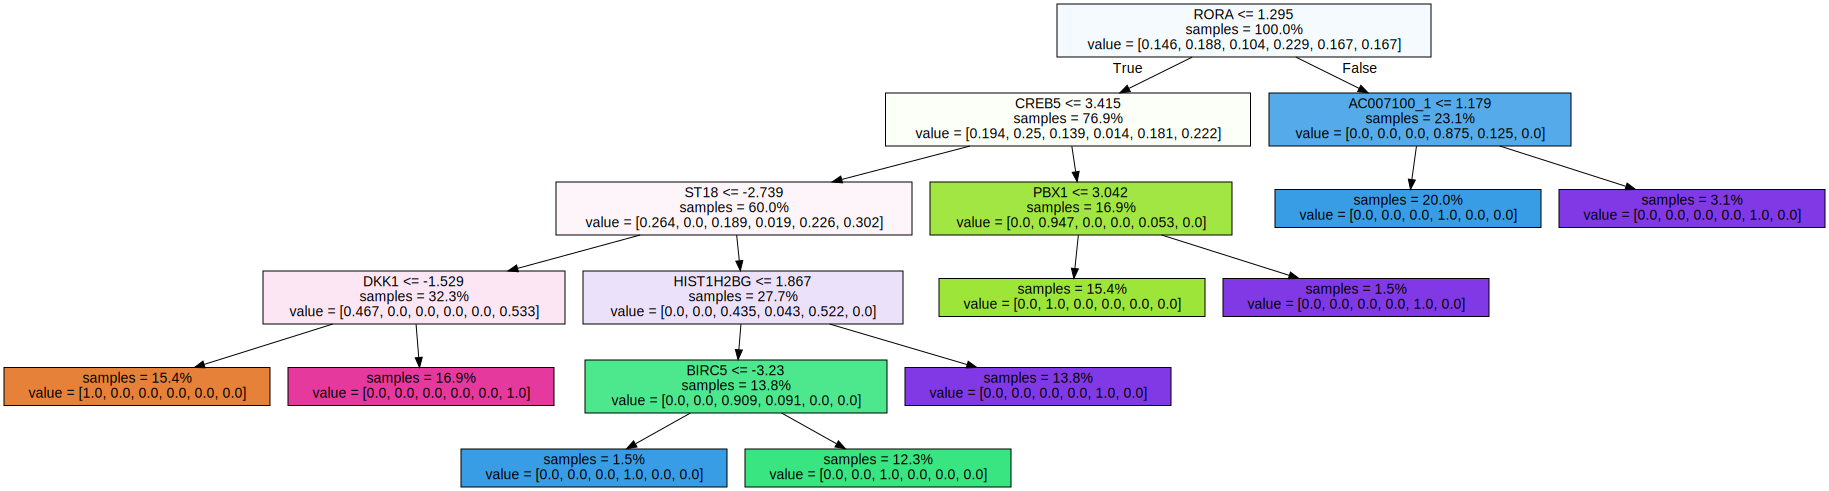

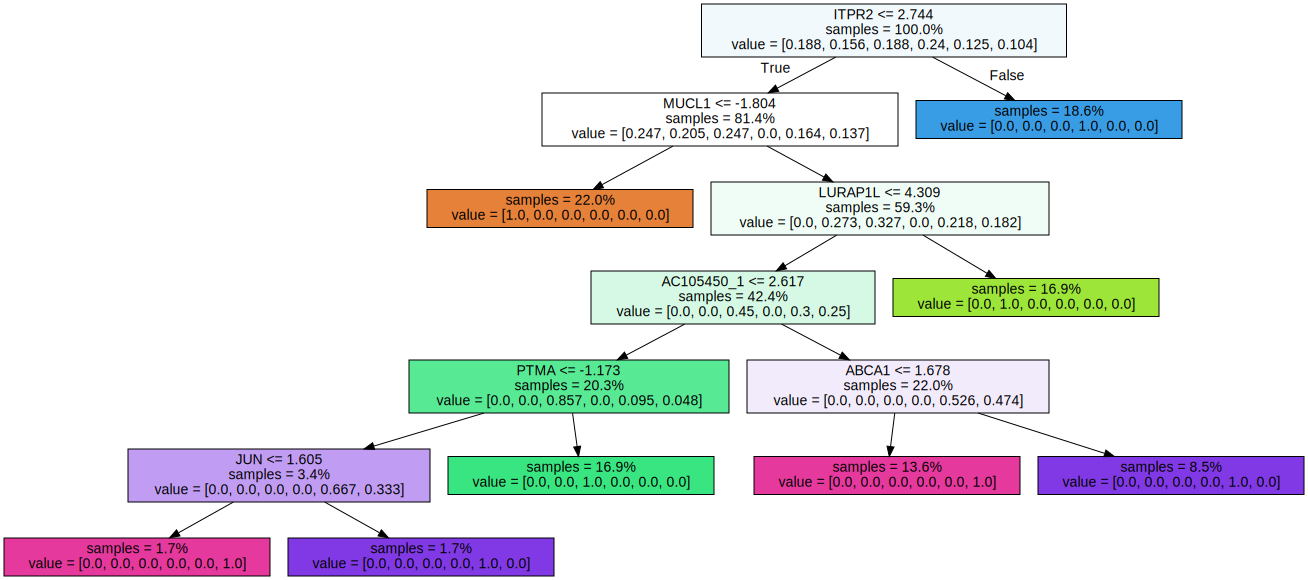

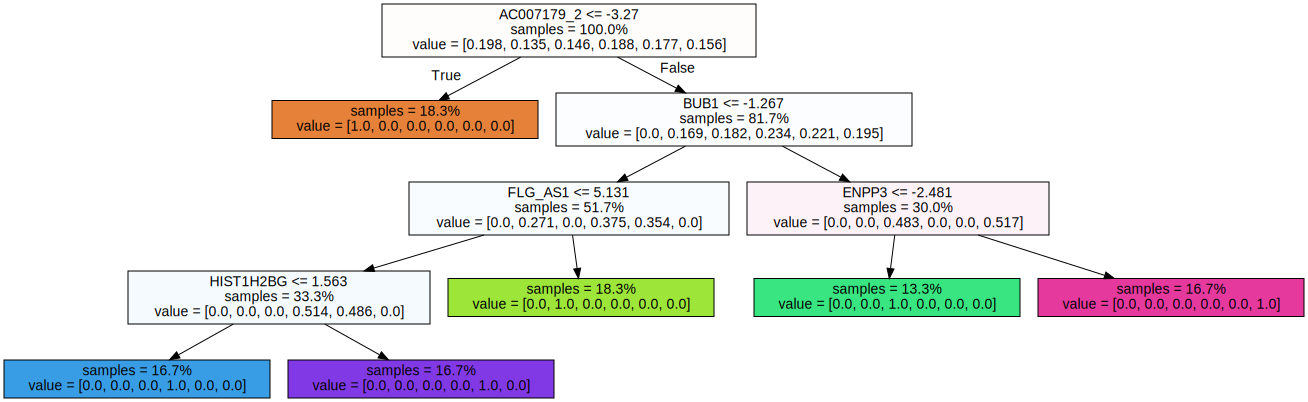

In [12]:
# export the first i decision trees from the forest

for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=pivot_24.columns,  
                               filled=True,  
                               max_depth=8, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [15]:
y_pred = best_rf.predict(X_72_train)
accuracy = accuracy_score(y_72_train, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5833333333333334


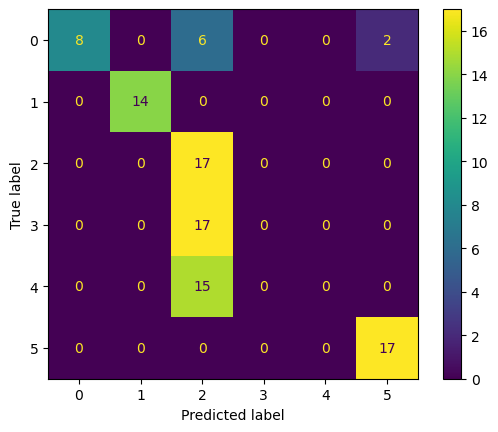

In [16]:
# Create the confusion matrix
cm = confusion_matrix(y_72_train, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

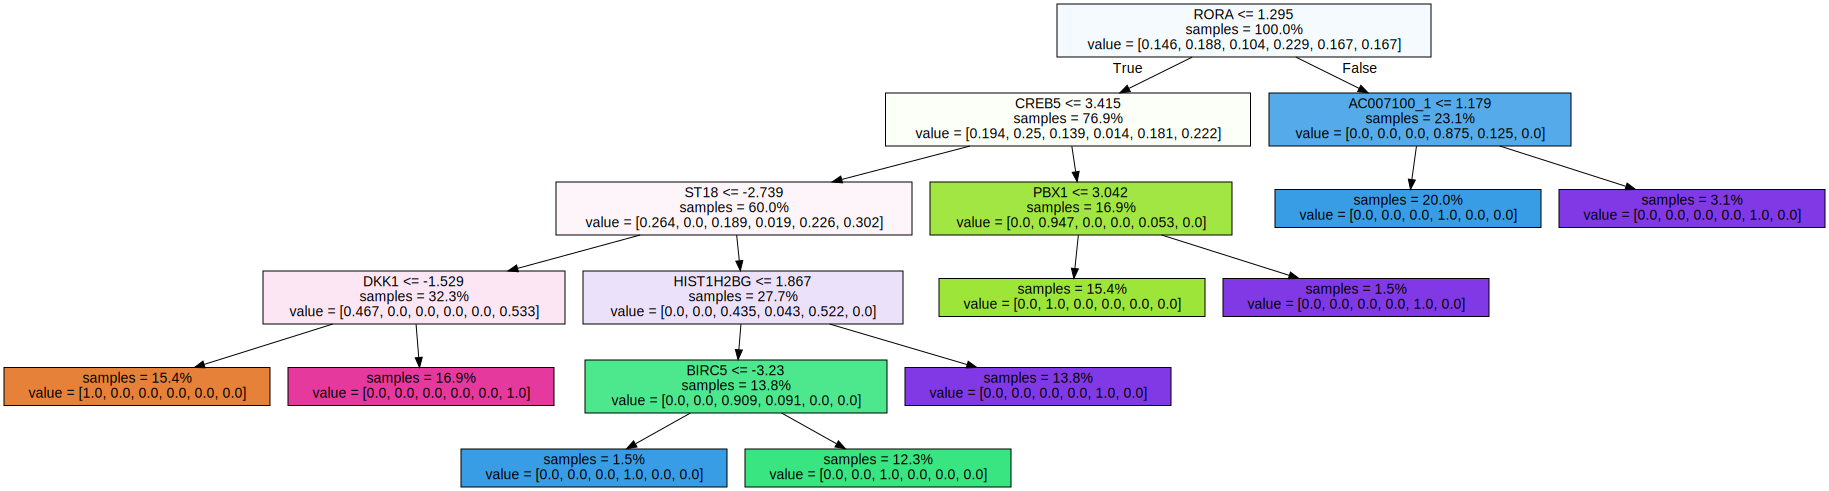

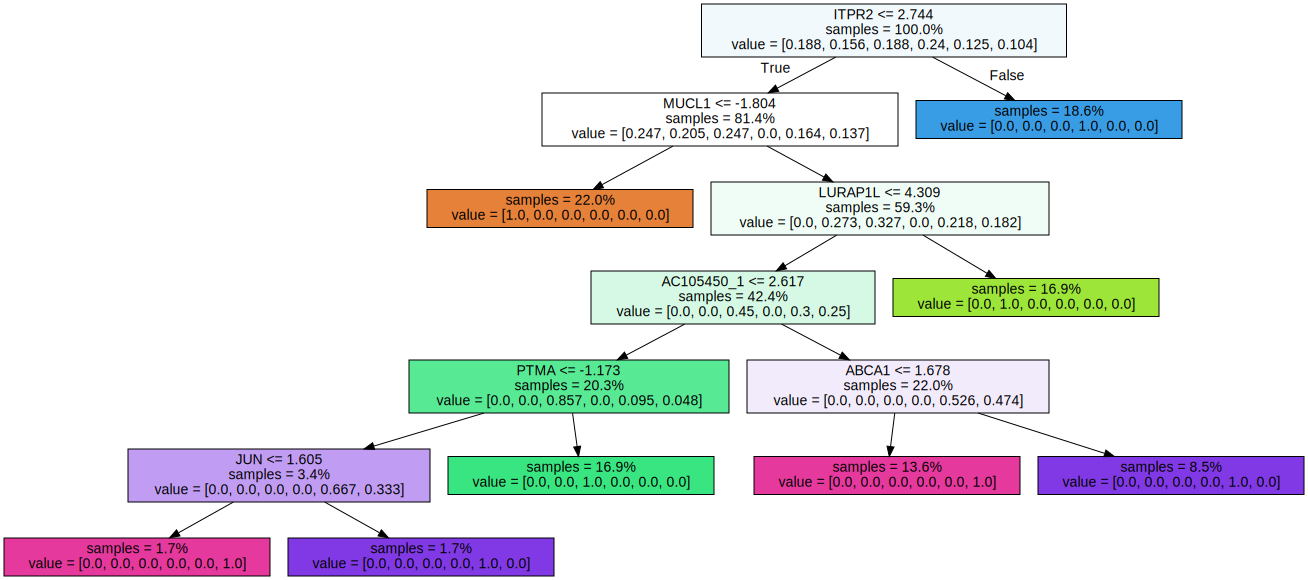

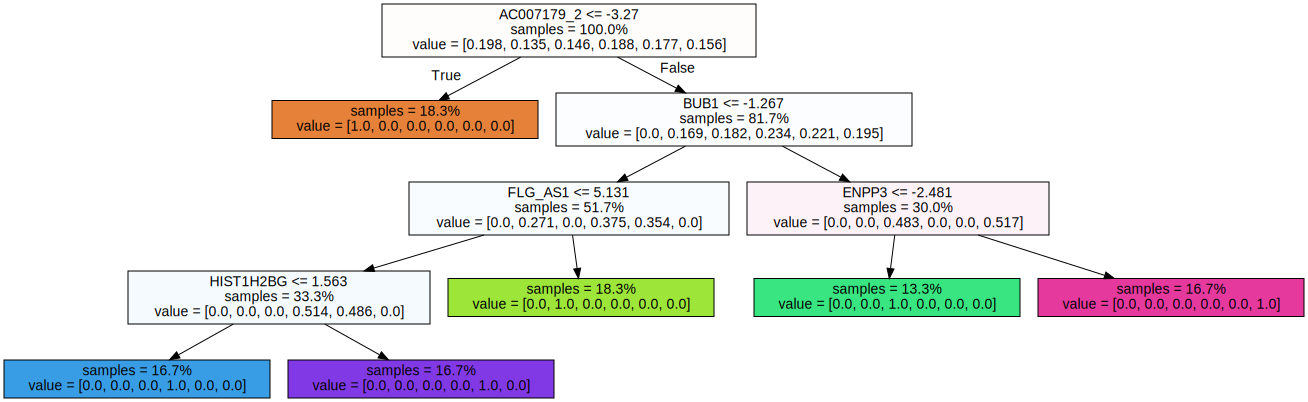

In [17]:
# export the first i decision trees from the forest

for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=pivot_72.columns,  
                               filled=True,  
                               max_depth=8, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

### Initial XGB model construction

After moving on from RF, I used XGB with a CV randomized search to select hyperparameters. Features were also ranked although in early iterations I was passing arrays into functions hence the lack of name (later sections have fixed this). When compared the depth of trees in RF, trees were generally much more pruned. Overfitting was likely at least partially mitigated as a result. Performance in testing against coefficients at 72 hours was superior to that of RF models.

In [86]:
model = XGBClassifier(objective = 'multi:softmax',
                      num_class = 6)

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(3,20),
              'learning_rate': [0.1, 0.2, 0.3],
              'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
              }

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_24, y_24)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=6, num_parallel_tree=None, ...),
                   n_iter=50,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x151f10cc4210>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x151f16f26c10>,
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]})

In [21]:
rand_search.best_params_

{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 494, 'subsample': 0.7}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

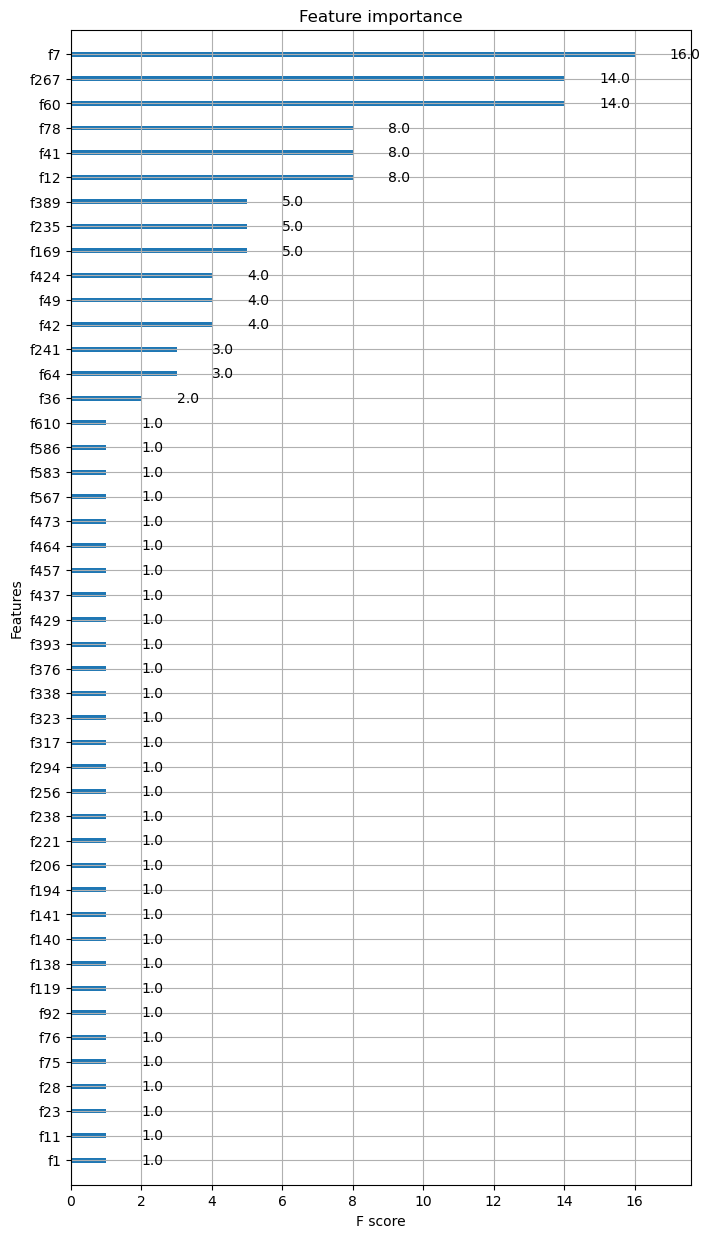

In [27]:
xgb_tuned = XGBClassifier(learning_rate = 0.3,
                          max_depth = 10,
                          n_estimators = 494,
                          subsample = 0.7)

fig, ax = plt.subplots(figsize = (8, 15))
xgb_tuned.fit(X_24, y_24)
plot_importance(xgb_tuned, ax = ax)

<Figure size 640x480 with 0 Axes>

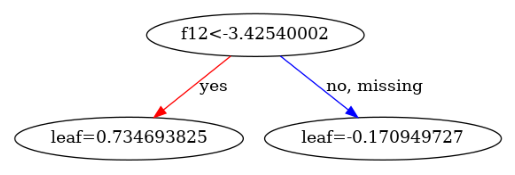

<Figure size 640x480 with 0 Axes>

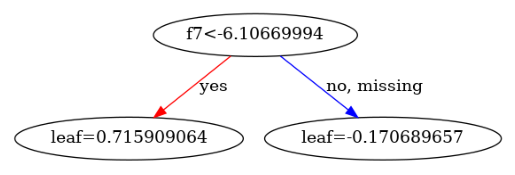

<Figure size 640x480 with 0 Axes>

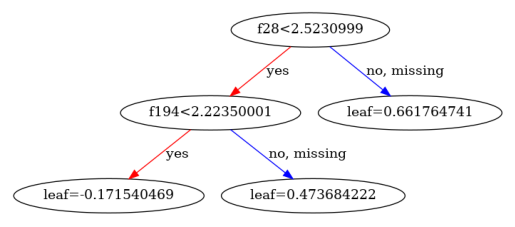

<Figure size 640x480 with 0 Axes>

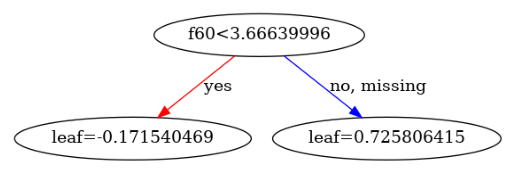

<Figure size 640x480 with 0 Axes>

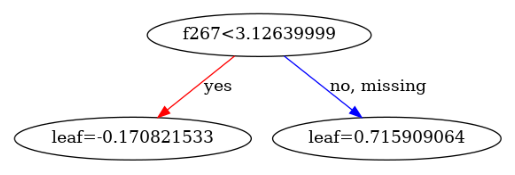

<Figure size 640x480 with 0 Axes>

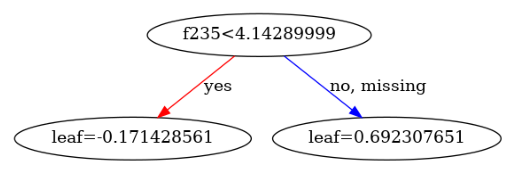

<Figure size 640x480 with 0 Axes>

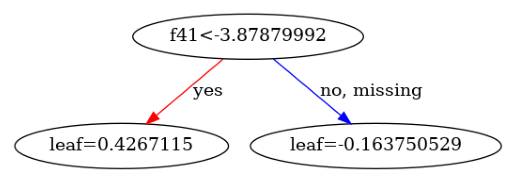

<Figure size 640x480 with 0 Axes>

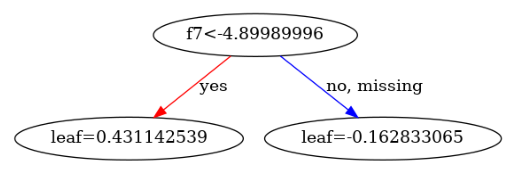

<Figure size 640x480 with 0 Axes>

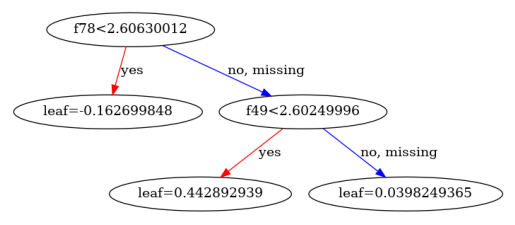

<Figure size 640x480 with 0 Axes>

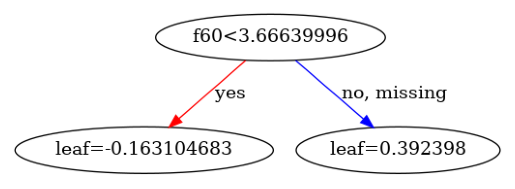

In [28]:
for i in range(0, 10):
    plt.figure()
    plot_tree(xgb_tuned, num_trees = i)

plt.show()

In [29]:
predictions = xgb_tuned.predict(X_72)
accuracy = accuracy_score(y_72, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 60.00%


In [30]:
print(classification_report(y_72, predictions))

              precision    recall  f1-score   support

           0       0.90      0.45      0.60        20
           1       1.00      0.85      0.92        20
           2       0.38      1.00      0.56        20
           3       0.35      0.40      0.37        20
           4       0.00      0.00      0.00        20
           5       1.00      0.90      0.95        20

    accuracy                           0.60       120
   macro avg       0.61      0.60      0.57       120
weighted avg       0.61      0.60      0.57       120



/lustre/scratch125/casm/team215mg/pg21_rotation/software/miniforge3/envs/xgboost/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/scratch125/casm/team215mg/pg21_rotation/software/miniforge3/envs/xgboost/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/scratch125/casm/team215mg/pg21_rotation/software/miniforge3/envs/xgboost/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in la

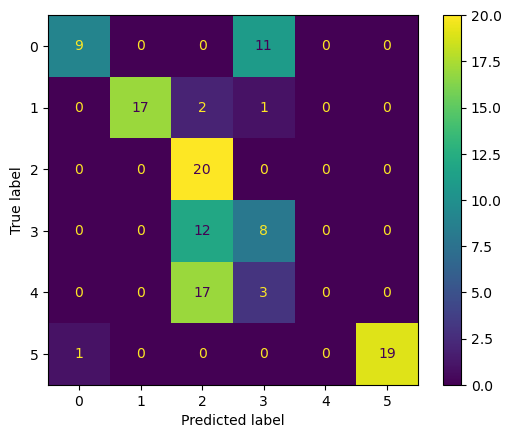

In [26]:
cm = confusion_matrix(y_72, predictions)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [42]:
pivot_24.columns[267]

'HIST1H2BG'

### Experimenting with using parameter distributions

Here I tested using distributions of parameters instead of a discrete number of them for my randomized search CV function. This resulted in a slight increase in performance. I also passed the data frame directly here instead of arrays so features were ordered with direct reference to their names.

In [2]:
coefficients = pd.DataFrame()
timepoints = ['24', '48', '72']

for rep in range(1,11):
    for time in timepoints:
        temp_coeff = pd.read_csv(f'/lustre/scratch125/casm/team215mg/pg21_rotation/Coefficients_CellDrift/selection_rep_{rep}/Contrast_Coefficients_time_{time}.txt', sep = '\t')
        temp_coeff['contrast'] = temp_coeff['contrast'] + f'_{rep}'
        temp_coeff['time'] = time
        coefficients = pd.concat([coefficients, temp_coeff], ignore_index = True)

coefficients['cell_type'] = coefficients['cell_type'].str.split(',', n = 1).str.get(-1).str.split("'").str.get(-2)
coefficients['perturbation'] = coefficients['perturbation'].str.split(',', n = 1).str.get(0).str.split("'").str.get(-2)
coefficients['cell_type'] = coefficients['cell_type'].map({'Fetal':0, 'Stem':1, 'Cycling':2, 'Secretory':3, 'Stress':4, 'Respiration':5})

coefficients = coefficients[coefficients['p_fdr'] < 0.05]
coefficients = coefficients[(coefficients['perturbation'] == 'MRTX1133_SHP099') | (coefficients['perturbation'] == 'MRTX1133_afatinib')]

coefficients

,contrast,cell_type,perturbation,mean,lci,uci,SE,z,p,p_fdr,pts_contrast,pts_reference,gene,time
1,Cycling_MRTX1133_SHP099-Cycling_DMSO_1,2,MRTX1133_SHP099,1.0593,1.7051,0.4136,0.3295,3.2152,0.0013,0.007800,0.219178,0.123333,ABAT,24
2,Cycling_MRTX1133_afatinib-Cycling_DMSO_1,2,MRTX1133_afatinib,1.0974,1.8266,0.3682,0.3721,2.9495,0.0032,0.016258,0.200000,0.123333,ABAT,24
6,Fetal_MRTX1133_SHP099-Fetal_DMSO_1,0,MRTX1133_SHP099,-0.6763,-0.2199,-1.1328,0.2329,-2.9040,0.0037,0.017794,0.350000,0.360000,ABAT,24
12,Stem_MRTX1133_afatinib-Stem_DMSO_1,1,MRTX1133_afatinib,0.5909,1.0459,0.1360,0.2321,2.5460,0.0109,0.040875,0.240000,0.213333,ABAT,24
21,Secretory_MRTX1133_SHP099-Secretory_DMSO_1,3,MRTX1133_SHP099,1.1338,1.7421,0.5256,0.3103,3.6536,0.0003,0.002821,0.330000,0.193333,ABAT,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733407,Stress_MRTX1133_afatinib-Stress_DMSO_10,4,MRTX1133_afatinib,0.7520,1.1432,0.3608,0.1996,3.7678,0.0002,0.001167,0.410000,0.316667,ZNF608,72
733421,Stem_MRTX1133_SHP099-Stem_DMSO_10,1,MRTX1133_SHP099,0.9310,1.5766,0.2854,0.3294,2.8264,0.0047,0.016269,0.210000,0.186667,ZNF704,72
733422,Stem_MRTX1133_afatinib-Stem_DMSO_10,1,MRTX1133_afatinib,1.1982,1.8086,0.5878,0.3114,3.8475,0.0001,0.000630,0.200000,0.186667,ZNF704,72
733436,Stress_MRTX1133_SHP099-Stress_DMSO_10,4,MRTX1133_SHP099,0.9426,1.5070,0.3782,0.2880,3.2734,0.0011,0.004779,0.160000,0.126667,ZNF704,72


In [132]:
pivot = coefficients.pivot_table('z', ['contrast', 'cell_type', 'time'], 'gene').fillna(0)
pivot.reset_index(drop = False, inplace = True)
pivot

gene,contrast,cell_type,time,ABAT,ABCA1,ABCA12,ABCB1,ABHD2,ABHD6,ABTB2,...,Z93403_1,ZBTB10,ZBTB20,ZBTB7C,ZFPM2,ZHX2,ZNF165,ZNF608,ZNF704,ZNF831
0,Cycling_MRTX1133_SHP099-Cycling_DMSO_1,2,24,3.2152,3.1070,0.0000,0.0000,0.0000,0.0,0.0000,...,2.9409,2.6872,2.8995,0.0,0.0,0.000,0.0000,0.0000,5.5932,0.0
1,Cycling_MRTX1133_SHP099-Cycling_DMSO_1,2,48,0.0000,2.2790,0.0000,0.0000,0.0000,0.0,0.0000,...,5.1887,0.0000,4.0087,0.0,0.0,3.349,0.0000,0.0000,4.6550,0.0
2,Cycling_MRTX1133_SHP099-Cycling_DMSO_1,2,72,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,2.8306,...,5.4727,0.0000,0.0000,0.0,0.0,0.000,0.0000,0.0000,2.9951,0.0
3,Cycling_MRTX1133_SHP099-Cycling_DMSO_10,2,24,3.4190,3.6973,0.0000,0.0000,0.0000,0.0,0.0000,...,0.0000,3.6377,2.8241,0.0,0.0,0.000,0.0000,0.0000,5.1164,0.0
4,Cycling_MRTX1133_SHP099-Cycling_DMSO_10,2,48,3.2930,3.2890,0.0000,0.0000,0.0000,0.0,0.0000,...,3.7095,0.0000,3.6944,0.0,0.0,0.000,0.0000,0.0000,5.0373,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Stress_MRTX1133_afatinib-Stress_DMSO_8,4,48,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,...,4.8749,2.6989,2.5422,0.0,0.0,0.000,3.0322,0.0000,2.5362,0.0
356,Stress_MRTX1133_afatinib-Stress_DMSO_8,4,72,0.0000,0.0000,0.0000,2.8247,-3.0268,0.0,2.5396,...,5.9887,0.0000,0.0000,0.0,0.0,0.000,0.0000,2.8822,0.0000,0.0
357,Stress_MRTX1133_afatinib-Stress_DMSO_9,4,24,0.0000,3.3562,0.0000,0.0000,0.0000,0.0,0.0000,...,0.0000,4.7772,0.0000,0.0,0.0,0.000,0.0000,0.0000,0.0000,0.0
358,Stress_MRTX1133_afatinib-Stress_DMSO_9,4,48,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,2.6117,...,4.9788,3.3366,3.8675,0.0,0.0,0.000,3.1875,0.0000,0.0000,0.0


In [133]:
pivot_24 = pivot[pivot['time'] == '24']
pivot_48 = pivot[pivot['time'] == '48']
pivot_72 = pivot[pivot['time'] == '72']
y_24 = pivot_24['cell_type'].to_numpy()
y_48 = pivot_48['cell_type'].to_numpy()
y_72 = pivot_72['cell_type'].to_numpy()

In [134]:
pivot_24.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_24 = pivot_24.to_numpy()
pivot_48.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_48 = pivot_48.to_numpy()
pivot_72.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_72 = pivot_72.to_numpy()
pivot_24

/tmp/ipykernel_2402185/207519375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_24.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)
/tmp/ipykernel_2402185/207519375.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_48.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)
/tmp/ipykernel_2402185/207519375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_72.drop(['contrast', 'cell_t

gene,ABAT,ABCA1,ABCA12,ABCB1,ABHD2,ABHD6,ABTB2,AC002451_1,AC003958_2,AC005062_1,...,Z93403_1,ZBTB10,ZBTB20,ZBTB7C,ZFPM2,ZHX2,ZNF165,ZNF608,ZNF704,ZNF831
0,3.2152,3.1070,0.000,0.000,0.0,0.0,0.0000,-4.6457,0.0,0.0,...,2.9409,2.6872,2.8995,0.0,0.0,0.0,0.0,0.000,5.5932,0.0
3,3.4190,3.6973,0.000,0.000,0.0,0.0,0.0000,-4.4766,0.0,0.0,...,0.0000,3.6377,2.8241,0.0,0.0,0.0,0.0,0.000,5.1164,0.0
6,2.9620,3.8301,0.000,0.000,0.0,0.0,0.0000,-4.0424,0.0,0.0,...,0.0000,4.1826,2.3463,0.0,0.0,0.0,0.0,0.000,5.5870,0.0
9,3.8093,2.3193,0.000,3.224,0.0,0.0,0.0000,-4.7807,0.0,0.0,...,0.0000,3.4902,2.5455,0.0,0.0,0.0,0.0,0.000,5.9215,0.0
12,3.9177,3.1448,0.000,0.000,0.0,0.0,0.0000,-4.4329,0.0,0.0,...,0.0000,3.2153,2.7806,0.0,0.0,0.0,0.0,0.000,4.7693,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0.0000,5.6480,0.000,0.000,0.0,0.0,0.0000,0.0000,0.0,0.0,...,3.0094,5.2139,0.0000,0.0,0.0,0.0,0.0,0.000,0.0000,0.0
348,0.0000,3.7012,0.000,0.000,0.0,0.0,3.0180,-3.0350,0.0,0.0,...,0.0000,4.9031,0.0000,0.0,0.0,0.0,0.0,0.000,0.0000,0.0
351,0.0000,4.8862,0.000,0.000,0.0,0.0,3.4529,0.0000,0.0,0.0,...,0.0000,3.7768,0.0000,0.0,0.0,0.0,0.0,0.000,0.0000,0.0
354,0.0000,5.2278,3.574,0.000,0.0,0.0,0.0000,-2.4384,0.0,0.0,...,3.2075,5.3845,0.0000,0.0,0.0,0.0,0.0,2.473,0.0000,0.0


In [135]:
X_24_train, X_24_test, y_24_train, y_24_test = train_test_split(X_24, y_24, test_size = 0.2)
X_48_train, X_48_test, y_48_train, y_48_test = train_test_split(X_48, y_48, test_size = 0.2)
X_72_train, X_72_test, y_72_train, y_72_test = train_test_split(X_72, y_72, test_size = 0.2)

In [7]:
model = XGBClassifier(objective = 'multi:softmax',
                      num_class = 6)

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(3,20),
              'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1],
              }

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(pivot_24, y_24)

/lustre/scratch125/casm/team215mg/pg21_rotation/software/miniforge3/envs/xgboost/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/lustre/scratch125/casm/team215mg/pg21_rotation/software/miniforge3/envs/xgboost/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/lustre/scratch125/casm/team215mg/pg21_rotation/software/miniforge3/envs/xgboost/lib/python3.13/site-packages/xgboost

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_class=6, num_parallel_tree=None, ...),
                   n_iter=50,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x152a447eae90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x152a10a5b620>,
                                        'subsample': [0.4, 0.5, 0.6, 0.7, 0.8,
                                                      0.9, 1.0, 1.1]})

In [8]:
rand_search.best_params_

{'learning_rate': 0.1, 'max_depth': 18, 'n_estimators': 394, 'subsample': 0.7}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

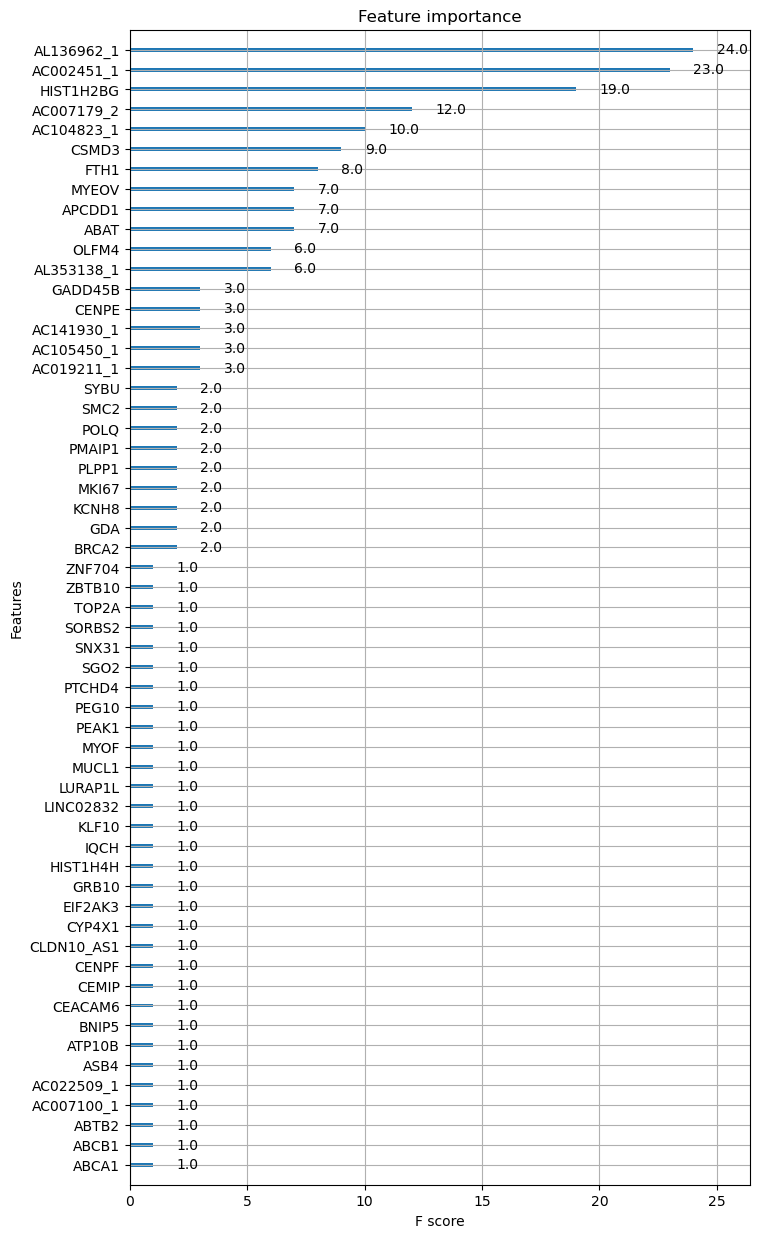

In [142]:
xgb_tuned = XGBClassifier(learning_rate = 0.2,
                          max_depth = 18,
                          n_estimators = 421,
                          subsample = 0.5)

fig, ax = plt.subplots(figsize = (8, 15))
xgb_tuned.fit(pivot_24, y_24)
plot_importance(xgb_tuned, ax = ax)

In [ ]:
for i in range(0, 10):
    plt.figure()
    plot_tree(xgb_tuned, num_trees = i)

plt.show()

In [143]:
predictions = xgb_tuned.predict(pivot_48)
accuracy = accuracy_score(y_72, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 65.00%


In [144]:
print(classification_report(y_72, predictions))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        20
           1       0.79      0.95      0.86        20
           2       0.38      0.90      0.54        20
           3       0.11      0.05      0.07        20
           4       1.00      0.35      0.52        20
           5       1.00      0.95      0.97        20

    accuracy                           0.65       120
   macro avg       0.71      0.65      0.63       120
weighted avg       0.71      0.65      0.63       120



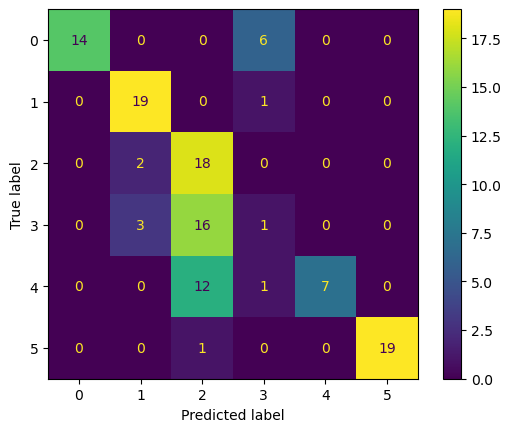

In [145]:
cm = confusion_matrix(y_72, predictions)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

### Removing significance filter and integrating deltas

As suggested by Clare, I removed the FDR filter as since sample size is mostly controlled for the z-scores are proportional to effect size, so in cases where coefficients are highly insignificant they will be close to 0 anyways.

Additionally I create a new pivot file and calculate pairwise deltas, this can take a while to run so it is also a standalone script. Testing the model performance, integrating deltas makes no difference in model performance. I have demonstrated an example where I only use deltas as predictors as I wanted to assess their individual importance. They are very poor predictors on their own, the model has very limited predictive power, so coefficients themselves need to be taken into account.

In [3]:
coefficients = pd.DataFrame()
timepoints = ['24', '48', '72']

for rep in range(1,11):
    for time in timepoints:
        temp_coeff = pd.read_csv(f'/lustre/scratch125/casm/team215mg/pg21_rotation/Coefficients_CellDrift/original/selection_rep_{rep}/Contrast_Coefficients_time_{time}.txt', sep = '\t')
        temp_coeff['contrast'] = temp_coeff['contrast'] + f'_{rep}'
        temp_coeff['time'] = time
        coefficients = pd.concat([coefficients, temp_coeff], ignore_index = True)

coefficients['cell_type'] = coefficients['cell_type'].str.split(',', n = 1).str.get(-1).str.split("'").str.get(-2)
coefficients['perturbation'] = coefficients['perturbation'].str.split(',', n = 1).str.get(0).str.split("'").str.get(-2)
coefficients['cell_type'] = coefficients['cell_type'].map({'Fetal':0, 'Stem':1, 'Cycling':2, 'Secretory':3, 'Stress':4, 'Respiration':5})

#coefficients = coefficients[coefficients['p_fdr'] < 0.05]
coefficients = coefficients[(coefficients['perturbation'] == 'MRTX1133_SHP099') | (coefficients['perturbation'] == 'MRTX1133_afatinib')]

coefficients

,contrast,cell_type,perturbation,mean,lci,uci,SE,z,p,p_fdr,pts_contrast,pts_reference,gene,time
1,Cycling_MRTX1133_SHP099-Cycling_DMSO_1,2,MRTX1133_SHP099,1.0593,1.7051,0.4136,0.3295,3.2152,0.0013,0.007800,0.219178,0.123333,ABAT,24
2,Cycling_MRTX1133_afatinib-Cycling_DMSO_1,2,MRTX1133_afatinib,1.0974,1.8266,0.3682,0.3721,2.9495,0.0032,0.016258,0.200000,0.123333,ABAT,24
6,Fetal_MRTX1133_SHP099-Fetal_DMSO_1,0,MRTX1133_SHP099,-0.6763,-0.2199,-1.1328,0.2329,-2.9040,0.0037,0.017794,0.350000,0.360000,ABAT,24
7,Fetal_MRTX1133_afatinib-Fetal_DMSO_1,0,MRTX1133_afatinib,-0.1212,0.2658,-0.5082,0.1975,-0.6139,0.5393,0.670136,0.430000,0.360000,ABAT,24
11,Stem_MRTX1133_SHP099-Stem_DMSO_1,1,MRTX1133_SHP099,0.3056,0.8021,-0.1909,0.2533,1.2065,0.2276,0.377337,0.240000,0.213333,ABAT,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733487,Respiration_MRTX1133_afatinib-Respiration_DMSO_10,5,MRTX1133_afatinib,0.0267,229754.7195,-229754.6662,117223.9361,0.0000,1.0000,1.000000,0.000000,0.000000,ZNF831,72
733491,Secretory_MRTX1133_SHP099-Secretory_DMSO_10,3,MRTX1133_SHP099,0.0239,277440.0052,-277439.9574,141553.6120,0.0000,1.0000,1.000000,0.000000,0.000000,ZNF831,72
733492,Secretory_MRTX1133_afatinib-Secretory_DMSO_10,3,MRTX1133_afatinib,-0.0707,681302.9532,-681303.0946,347609.9710,-0.0000,1.0000,1.000000,0.000000,0.000000,ZNF831,72
733496,Stress_MRTX1133_SHP099-Stress_DMSO_10,4,MRTX1133_SHP099,24.8449,107218.1735,-107168.4837,54691.4787,0.0005,0.9996,1.000000,0.010000,0.000000,ZNF831,72


In [3]:
pivot = coefficients.pivot_table('z', ['contrast', 'cell_type', 'time'], 'gene').fillna(0)
pivot.reset_index(drop = False, inplace = True)
pivot

gene,contrast,cell_type,time,ABAT,ABCA1,ABCA12,ABCB1,ABHD2,ABHD6,ABTB2,...,Z93403_1,ZBTB10,ZBTB20,ZBTB7C,ZFPM2,ZHX2,ZNF165,ZNF608,ZNF704,ZNF831
0,Cycling_MRTX1133_SHP099-Cycling_DMSO_1,2,24,3.2152,3.1070,0.0000,0.0000,0.0000,0.0,0.0000,...,2.9409,2.6872,2.8995,0.0,0.0,0.000,0.0000,0.0000,5.5932,0.0
1,Cycling_MRTX1133_SHP099-Cycling_DMSO_1,2,48,0.0000,2.2790,0.0000,0.0000,0.0000,0.0,0.0000,...,5.1887,0.0000,4.0087,0.0,0.0,3.349,0.0000,0.0000,4.6550,0.0
2,Cycling_MRTX1133_SHP099-Cycling_DMSO_1,2,72,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,2.8306,...,5.4727,0.0000,0.0000,0.0,0.0,0.000,0.0000,0.0000,2.9951,0.0
3,Cycling_MRTX1133_SHP099-Cycling_DMSO_10,2,24,3.4190,3.6973,0.0000,0.0000,0.0000,0.0,0.0000,...,0.0000,3.6377,2.8241,0.0,0.0,0.000,0.0000,0.0000,5.1164,0.0
4,Cycling_MRTX1133_SHP099-Cycling_DMSO_10,2,48,3.2930,3.2890,0.0000,0.0000,0.0000,0.0,0.0000,...,3.7095,0.0000,3.6944,0.0,0.0,0.000,0.0000,0.0000,5.0373,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Stress_MRTX1133_afatinib-Stress_DMSO_8,4,48,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,...,4.8749,2.6989,2.5422,0.0,0.0,0.000,3.0322,0.0000,2.5362,0.0
356,Stress_MRTX1133_afatinib-Stress_DMSO_8,4,72,0.0000,0.0000,0.0000,2.8247,-3.0268,0.0,2.5396,...,5.9887,0.0000,0.0000,0.0,0.0,0.000,0.0000,2.8822,0.0000,0.0
357,Stress_MRTX1133_afatinib-Stress_DMSO_9,4,24,0.0000,3.3562,0.0000,0.0000,0.0000,0.0,0.0000,...,0.0000,4.7772,0.0000,0.0,0.0,0.000,0.0000,0.0000,0.0000,0.0
358,Stress_MRTX1133_afatinib-Stress_DMSO_9,4,48,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,2.6117,...,4.9788,3.3366,3.8675,0.0,0.0,0.000,3.1875,0.0000,0.0000,0.0


In [56]:
pivot = pd.read_csv('/lustre/scratch125/casm/team215mg/pg21_rotation/all_pivot.tsv', sep = '\t')

In [125]:
for contrast in np.unique(coefficients['contrast']):
    print(contrast)
    coeff_filtered = pivot[pivot['contrast'] == contrast]
    for gene in np.unique(coefficients['gene']):
        print(gene)
        z_72 = coeff_filtered.loc[coeff_filtered['time'] == '72', [gene]]
        z_48 = coeff_filtered.loc[coeff_filtered['time'] == '48', [gene]]
        z_24 = coeff_filtered.loc[coeff_filtered['time'] == '24', [gene]]
        pivot.loc[((pivot['contrast'] == contrast) & (pivot['time'] == '24')), [f'{gene}_delta']] = z_24[gene].values[0] - z_48[gene].values[0]
        pivot.loc[((pivot['contrast'] == contrast) & (pivot['time'] == '48')), [f'{gene}_delta']] = z_48[gene].values[0] - z_24[gene].values[0]
        pivot.loc[((pivot['contrast'] == contrast) & (pivot['time'] == '72')), [f'{gene}_delta']] = z_72[gene].values[0] - z_48[gene].values[0]

Cycling_MRTX1133_SHP099-Cycling_DMSO_1
ABAT
ABCA1
ABCA12
ABCB1
ABHD2
ABHD6
ABTB2
AC002451_1
AC003958_2
AC005062_1
AC007099_1
AC007100_1
AC007179_2
AC007277_1
AC007368_1
AC007402_1
AC007405_1
AC010343_3
AC011287_1
AC011586_2
AC012405_1
AC012501_2
AC013287_1
AC013652_1
AC019211_1
AC019330_1
AC022509_1
AC026167_1
AC068413_1
AC068587_4
AC068633_1
AC073050_1
AC073114_1
AC073365_1
AC073529_1
AC083837_1
AC087857_1
AC092969_1
AC093083_1
AC093817_2
AC093866_1
AC098617_1
AC099560_1
AC104823_1
AC105450_1
AC105460_1
AC106795_2
AC106795_3
AC114811_2
AC127035_1
AC138356_3
AC139493_2
AC141930_1
ACER2
ACSL5
ACSS2
ADAMTS9
AGMO
AGR2
AHRR
AKAP12
AL008633_1
AL050309_1
AL136962_1
AL138828_1
AL139815_1
AL163953_1
AL353138_1
ALCAM
ALDH1A1
ALDH1A2
ALDH3A1
AMACR
AMIGO2
AMOT
ANGPT2
ANKEF1
ANLN
ANXA1
ANXA3
AOAH
APCDD1
APLF
APOLD1
AREG
ARHGAP29
ARHGAP42
ARHGEF38
ASAH2
ASB4
ASCL2
ASPM
ASS1
ATAD2
ATF3
ATP10B
ATP2B4
ATP5F1E
ATP5IF1
ATP5MC1
ATP5MD
ATP5ME
ATP5MPL
ATXN1
B4GALNT3
BACH2
BARD1
BBS9
BEST3
BIRC3
BIRC5
BMP4


In [4]:
pivot_24 = pivot[pivot['time'] == 24]
pivot_48 = pivot[pivot['time'] == 48]
pivot_72 = pivot[pivot['time'] == 72]
y_24 = pivot_24['cell_type'].to_numpy()
y_48 = pivot_48['cell_type'].to_numpy()
y_72 = pivot_72['cell_type'].to_numpy()

In [5]:
pivot_24.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_24 = pivot_24.to_numpy()
pivot_48.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_48 = pivot_48.to_numpy()
pivot_72.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_72 = pivot_72.to_numpy()
X_48

/tmp/ipykernel_3443936/3571589583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_24.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)
/tmp/ipykernel_3443936/3571589583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_48.drop(['contrast', 'cell_type', 'time'], axis = 1, inplace = True)
/tmp/ipykernel_3443936/3571589583.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_72.drop(['contrast', 'cel

array([], shape=(0, 656), dtype=float64)

In [219]:
X_24_train, X_24_test, y_24_train, y_24_test = train_test_split(X_24, y_24, test_size = 0.2)
X_48_train, X_48_test, y_48_train, y_48_test = train_test_split(X_48, y_48, test_size = 0.2)
X_72_train, X_72_test, y_72_train, y_72_test = train_test_split(X_72, y_72, test_size = 0.2)

In [7]:
model = XGBClassifier(objective = 'multi:softmax',
                      num_class = 6)

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(3,20),
              'learning_rate': [0.1, 0.2, 0.3],
              'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
              }

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter=100, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_24, y_24)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_class=6, num_parallel_tree=None, ...),
                   n_iter=100,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14d05f047250>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14d02f2bfb60>,
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]})

In [8]:
rand_search.best_params_

{'learning_rate': 0.3, 'max_depth': 18, 'n_estimators': 486, 'subsample': 0.7}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

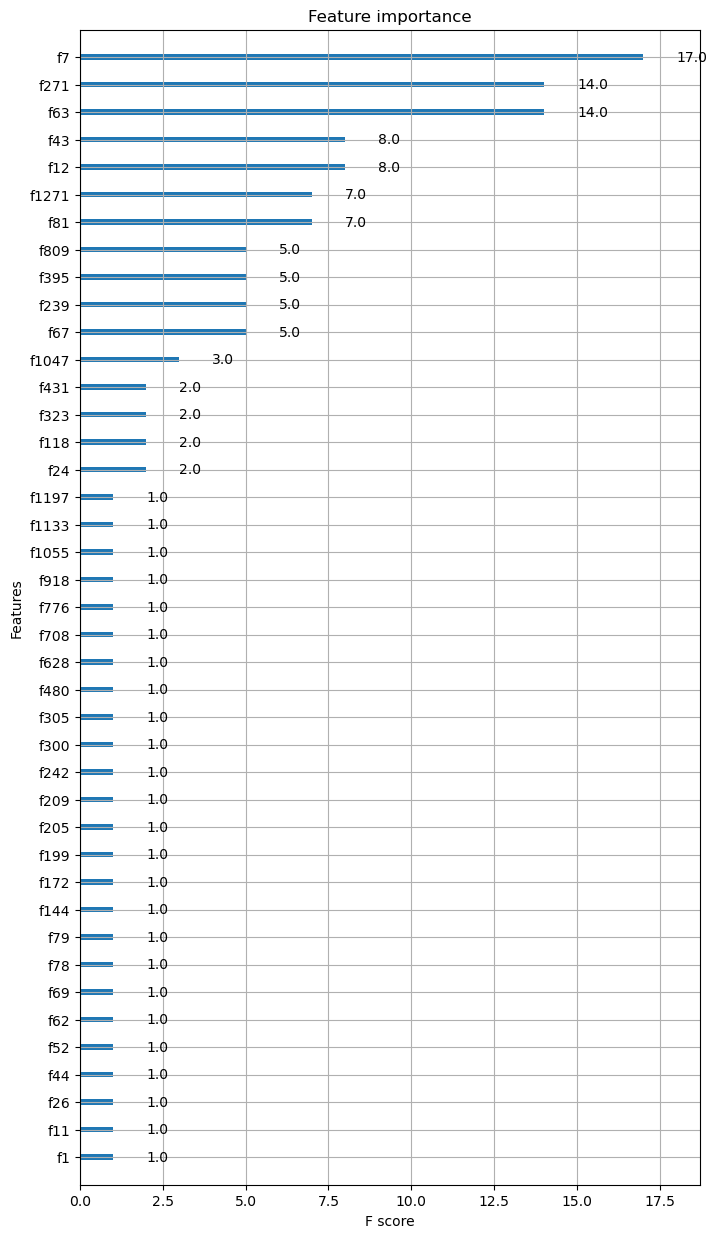

In [72]:
xgb_tuned = XGBClassifier(learning_rate = 0.3,
                          max_depth = 18,
                          n_estimators = 486,
                          subsample = 0.7)

fig, ax = plt.subplots(figsize = (8, 15))
xgb_tuned.fit(X_24, y_24)
plot_importance(xgb_tuned, ax = ax)

In [ ]:
for i in range(0, 10):
    plt.figure()
    plot_tree(xgb_tuned, num_trees = i)

plt.show()

In [73]:
predictions = xgb_tuned.predict(X_72)
accuracy = accuracy_score(y_72, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 45.83%


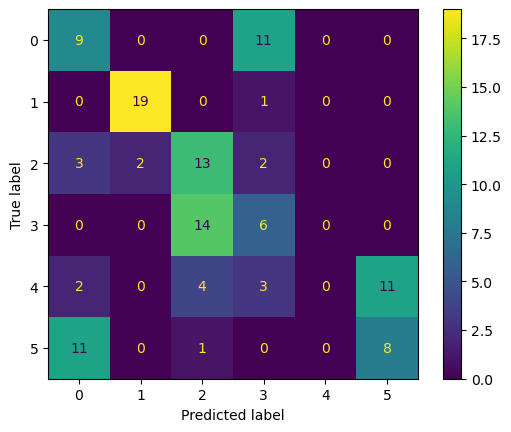

In [74]:
cm = confusion_matrix(y_72, predictions)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

### Using validation when training model while optimizing hyperparameters

The model substantially improves when allowing a validation set and also widening gthe range of parameter distributions. I have also ranked predictors on importance but as can be seen, integrating deltas leads to a lot of predictors with some amount of importance. I also compare predictors between the model constructed using 24h coefficients against the model constructed using 72h coefficients.

In [4]:
pivot = pd.read_csv('/lustre/scratch125/casm/team215mg/pg21_rotation/all_pivot.tsv', sep = '\t')

In [5]:
pivot_24 = pivot[pivot['time'] == 24]
pivot_48 = pivot[pivot['time'] == 48]
pivot_72 = pivot[pivot['time'] == 72]
y_24 = pivot_24['cell_type'].to_numpy()
y_48 = pivot_48['cell_type'].to_numpy()
y_72 = pivot_72['cell_type'].to_numpy()

In [6]:
for gene in np.unique(coefficients['gene']):
    pivot_24[f'{gene}_delta'] = pivot_48[f'{gene}_delta'].values
    pivot_48[f'{gene}_delta'] = pivot_72[f'{gene}_delta'].values

/tmp/ipykernel_1504223/1922417773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_24[f'{gene}_delta'] = pivot_48[f'{gene}_delta'].values
/tmp/ipykernel_1504223/1922417773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_48[f'{gene}_delta'] = pivot_72[f'{gene}_delta'].values


In [7]:
pivot_24.drop(['Unnamed: 0', 'contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_24 = pivot_24.to_numpy()
pivot_48.drop(['Unnamed: 0', 'contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_48 = pivot_48.to_numpy()
pivot_72.drop(['Unnamed: 0', 'contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_72 = pivot_72.to_numpy()
X_48

/tmp/ipykernel_1504223/768850682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_24.drop(['Unnamed: 0', 'contrast', 'cell_type', 'time'], axis = 1, inplace = True)
/tmp/ipykernel_1504223/768850682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_48.drop(['Unnamed: 0', 'contrast', 'cell_type', 'time'], axis = 1, inplace = True)
/tmp/ipykernel_1504223/768850682.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_

array([[ 2.2450e+00,  2.2790e+00,  2.7905e+00, ..., -1.6599e+00,
        -3.5490e-01,  0.0000e+00],
       [ 3.2930e+00,  3.2890e+00,  7.1580e-01, ..., -3.4737e+00,
         9.9380e-01,  0.0000e+00],
       [ 3.7158e+00,  2.4421e+00,  1.9676e+00, ..., -1.4243e+00,
         3.9620e-01,  1.0000e-04],
       ...,
       [ 2.3563e+00,  1.5860e+00,  8.6050e-01, ..., -1.8477e+00,
        -1.5189e+00,  0.0000e+00],
       [ 1.5594e+00,  4.5710e-01,  1.3748e+00, ..., -7.2690e-01,
        -2.5763e+00,  0.0000e+00],
       [ 1.7211e+00,  2.5660e-01,  1.0695e+00, ...,  2.9550e-01,
        -2.2709e+00,  1.0000e-04]])

In [8]:
X_24_train, X_24_test, y_24_train, y_24_test = train_test_split(pivot_24, y_24, test_size = 0.2)
X_48_train, X_48_test, y_48_train, y_48_test = train_test_split(pivot_48, y_48, test_size = 0.2)
X_72_train, X_72_test, y_72_train, y_72_test = train_test_split(pivot_72, y_72, test_size = 0.2)

In [31]:
model = XGBClassifier(objective = 'multi:softmax',
                      num_class = 6)

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(3,20),
              'learning_rate': np.random.uniform(0.1, 0.5, 100),
              'subsample': np.random.uniform(0.1, 1, 100)
              }

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter = 20, 
                                 cv = 5)

# Fit the random search object to the data
rand_search.fit(X_72_train, y_72_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
       0.77433601, 0.29613771, 0.27410934, 0.3748473 , 0.15626416,
       0.67246453, 0.86961926, 0.18421503, 0.55302155, 0.54019021,
       0.89687197, 0.6015538 , 0.21060803, 0.32455562, 0.36643502,
       0.6267722 , 0.40531575, 0.41950298, 0.68819193, 0.91881082,
       0.61651523, 0.51728732, 0.19846136, 0.36981736, 0.45736621,
       0.4210451 , 0.84064327, 0.92287114, 0.58784414, 0.68286243,
       0.33712214, 0.51590695, 0.64383594, 0.49975559, 0.98030395])})

In [32]:
rand_search.best_params_

{'learning_rate': np.float64(0.21894256057054304),
 'max_depth': 13,
 'n_estimators': 281,
 'subsample': np.float64(0.1984613621945694)}

In [12]:
xgb_tuned = XGBClassifier(learning_rate = 0.2,
                          max_depth = 18,
                          n_estimators = 421,
                          subsample = 0.2,
                          early_stopping_rounds = 20)
xgb_tuned.fit(pivot_24, y_24, eval_set = [(pivot_72, y_72)])

[0]	validation_0-mlogloss:1.63442
[1]	validation_0-mlogloss:1.54290
[2]	validation_0-mlogloss:1.46387
[3]	validation_0-mlogloss:1.40478
[4]	validation_0-mlogloss:1.39880
[5]	validation_0-mlogloss:1.33762
[6]	validation_0-mlogloss:1.30582
[7]	validation_0-mlogloss:1.24711
[8]	validation_0-mlogloss:1.24646
[9]	validation_0-mlogloss:1.25016
[10]	validation_0-mlogloss:1.23319
[11]	validation_0-mlogloss:1.19476
[12]	validation_0-mlogloss:1.18071
[13]	validation_0-mlogloss:1.18607
[14]	validation_0-mlogloss:1.18951
[15]	validation_0-mlogloss:1.18401
[16]	validation_0-mlogloss:1.18909
[17]	validation_0-mlogloss:1.19494
[18]	validation_0-mlogloss:1.20693
[19]	validation_0-mlogloss:1.21000
[20]	validation_0-mlogloss:1.22600
[21]	validation_0-mlogloss:1.20910
[22]	validation_0-mlogloss:1.20340
[23]	validation_0-mlogloss:1.19708
[24]	validation_0-mlogloss:1.18563
[25]	validation_0-mlogloss:1.18385
[26]	validation_0-mlogloss:1.18521
[27]	validation_0-mlogloss:1.17615
[28]	validation_0-mlogloss:1.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=421, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:
predictions = xgb_tuned.predict(pivot_72)
accuracy = accuracy_score(y_72, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.17%


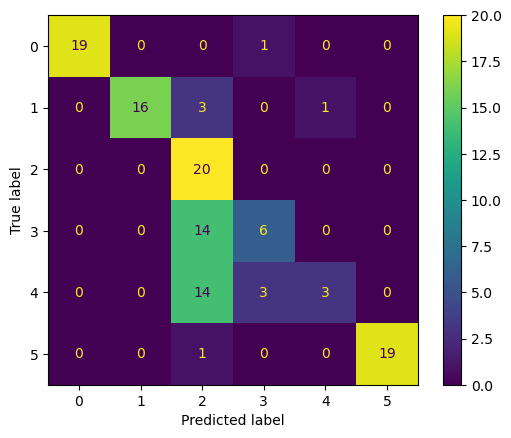

In [10]:
cm = confusion_matrix(y_72, predictions)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

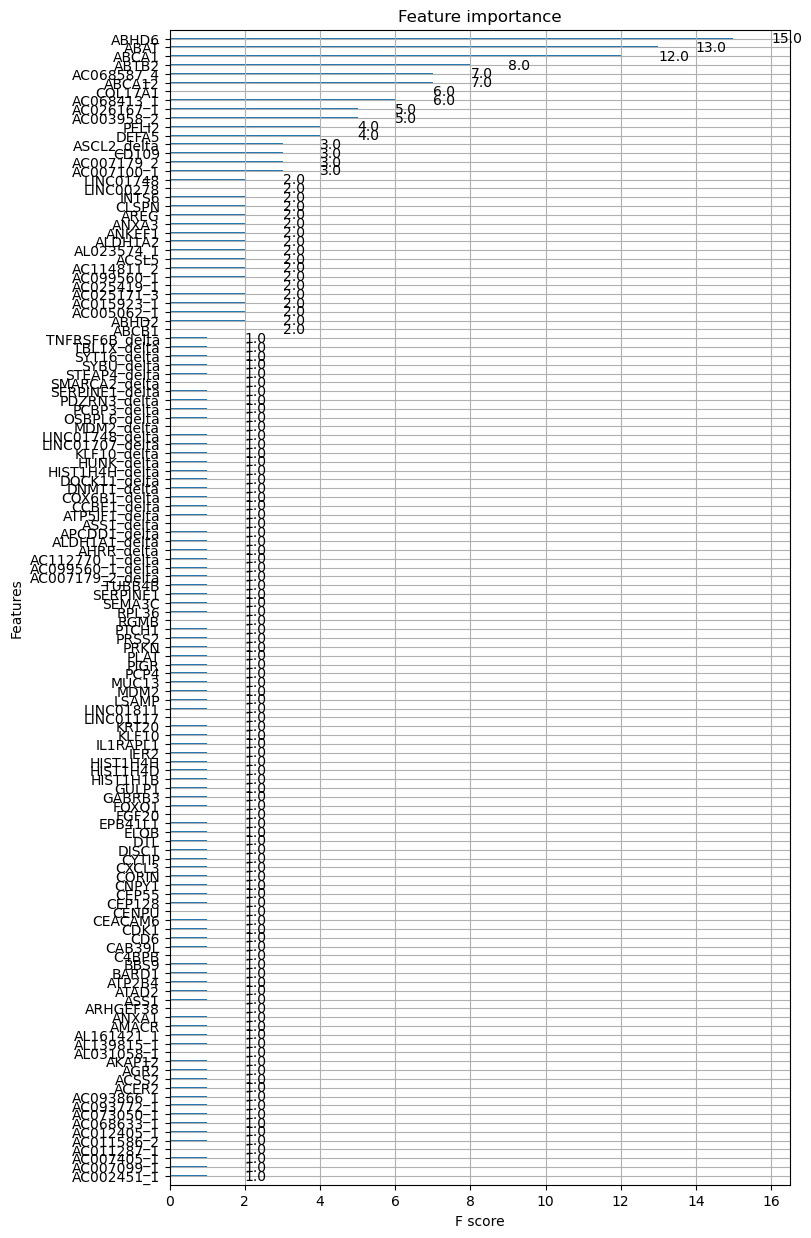

In [32]:
fig, ax = plt.subplots(figsize = (8, 15))
plot_importance(xgb_tuned, ax = ax)

In [10]:
results = pd.DataFrame()
results['columns'] = X_72_train.columns
results['importances'] = xgb_tuned.feature_importances_
results.sort_values(by = 'importances', ascending=False, inplace=True)

results[:20]

,columns,importances
417,KITLG,0.067506
346,GULP1,0.057782
31,AC011477_3,0.053927
221,CLSPN,0.038484
11,AC004704_1,0.037482
107,AL133372_2,0.030954
127,ANKEF1,0.027989
16,AC007100_1,0.023589
173,C4orf51,0.022446
134,APCDD1,0.021875


In [12]:
results_24 = pd.DataFrame()
results_24['columns'] = X_24_train.columns
results_24['importances'] = xgb_tuned.feature_importances_
results_24.sort_values(by = 'importances', ascending=False, inplace=True)

results_24[:20]

,columns,importances
169,BRIP1,0.115210
15,AC007099_1,0.065347
16,AC007100_1,0.041958
241,CSMD3,0.040101
43,AC025171_3,0.039629
24,AC008629_1,0.034049
18,AC007179_2,0.030421
70,AC104823_1,0.027579
4,ABHD2,0.025378
329,GADD45B,0.024778


In [48]:
pivot_24.columns[271]

'HIST1H2BG'

In [88]:
selection = SelectFromModel(xgb_tuned, threshold = 0.005, prefit = True)
selected_dataset = selection.transform(X_72)

In [89]:
selected_X24 = selection.transform(X_24)
selected_X24

array([[ 3.107 ,  0.    , -4.6457, ...,  0.1733,  3.3309,  1.095 ],
       [ 3.6973,  0.    , -4.4766, ...,  3.5996,  0.    ,  2.0468],
       [ 3.8301,  0.    , -4.0424, ...,  0.    ,  5.3699,  0.9084],
       ...,
       [ 4.8862,  3.4529,  0.    , ..., -2.7432,  0.    , -4.566 ],
       [ 5.2278,  0.    , -2.4384, ..., -3.7458,  0.    , -2.7176],
       [ 3.3562,  0.    , -2.5075, ..., -2.5871,  0.    , -1.8651]],
      shape=(120, 25))

In [90]:
model = XGBClassifier(objective = 'multi:softmax',
                      num_class = 6)

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(3,20),
              'learning_rate': [0.1, 0.2, 0.3],
              'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
              }

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter=20, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(selected_X24, y_24)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=6, num_parallel_tree=None, ...),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1525577b0050>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1525577b1310>,
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]})

In [91]:
rand_search.best_params_

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 252, 'subsample': 0.6}

In [92]:
xgb_tuned_new = XGBClassifier(learning_rate = 0.2,
                          max_depth = 5,
                          n_estimators = 252,
                          subsample = 0.6,
                          objective = "multi:softmax",
                          num_class = 6)
xgb_tuned_new.fit(selected_X24, y_24)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=252, n_jobs=None, num_class=6,
              num_parallel_tree=None, ...)

In [93]:
predictions_new = xgb_tuned_new.predict(selected_dataset)
accuracy_new = accuracy_score(y_72, predictions_new)
print("Accuracy: %.2f%%" % (accuracy_new * 100.0))

Accuracy: 56.67%


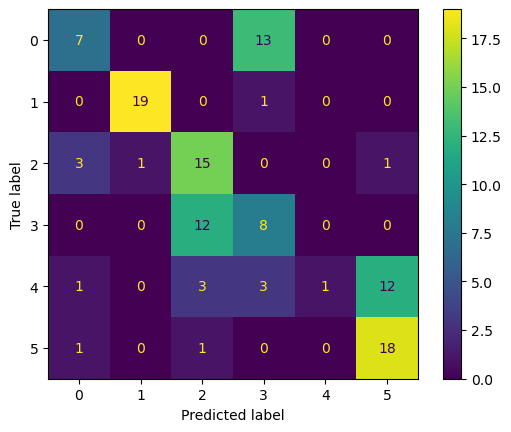

In [94]:
cm_new = confusion_matrix(y_72, predictions_new)

ConfusionMatrixDisplay(confusion_matrix=cm_new).plot()

In [9]:
features = [7,271,63,43,12,809,81,1271,239,395,1047,67,431,44,300,172,0,1008,496,361,242,113,62]
for f in features:
    print(pivot_24.columns[f])

AC002451_1
HIST1H2BG
AL136962_1
AC104823_1
AC007179_2
CHRM3_delta
APCDD1
TNFRSF19_delta
FTH1
MYEOV
MUC13_delta
AL353138_1
OLFM4
AC105450_1
INPP4B
CSMD3
ABAT
LINC02832_delta
RAB30
LURAP1L
GADD45B
BRCA2
AL050309_1


### Collinearity analysis

Includes individual iterations of collinearity matrix but mainly a few functions that assess collinearity between all predictors and other DEGs, then coinflips between predictors, then finally assess performance after coinflips have been conducted. This function can take a while depending on how many iterations are to be performed, I have also written it out as a separate script that will generate a distribution from the resulting accuracies. 

In [9]:
corr_matrix = pivot_24.corr(method = 'pearson')
corr_matrix = corr_matrix.stack()
corr_matrix = corr_matrix[((corr_matrix > 0.8)) & (corr_matrix != 1)]
corr_matrix = corr_matrix.to_frame()
corr_gene_list = np.unique(corr_matrix.index.get_level_values(0))
corr_matrix

0
ABAT         ASS1          0.821474
             ZBTB20        0.808042
AC002451_1   ASB4          0.814838
             XACT          0.823282
AC007100_1   NKD1          0.807462
...                             ...
WDPCP_delta  NKD1_delta    0.809414
WNK2_delta   FGF20_delta   0.801854
ZBTB20_delta NEAT1_delta   0.821800
             SYNE2_delta   0.804809
ZBTB7C_delta MT_ND5_delta  0.810607

[1188 rows x 1 columns]

In [20]:
corr_matrix[corr_matrix.index.get_level_values(0) == 'WNK2']

0
WNK2 ALCAM      0.802679
     ITPR2      0.830618
     NAALADL2   0.823690
     NKD1       0.848270
     PROX1_AS1  0.822938
     SERPINI1   0.819449
     TRPM3      0.812211
     TXNIP      0.814644

In [71]:
for gene in corr_gene_list:
    for corr in corr_matrix[corr_matrix.index.get_level_values(0) == gene].index.get_level_values(1):
        if corr in np.unique(corr_matrix.index.get_level_values(0)):
            corr_matrix.drop(labels = corr, axis = 0, inplace = True)

In [56]:
corr_matrix

0
AC002451_1  SAMD4A            0.719370
AC007132_1  AC007132_1_delta  0.775779
AC007179_2  AC114811_2        0.710280
            ALCAM             0.693678
            FGF20             0.680537
...                                ...
SMOC2_delta ITPR2_delta       0.818031
SYNE1_delta DKK4              0.730872
SYNE2_delta MT_ND5_delta      0.753198
            SYTL2_delta       0.713486
WDPCP_delta ITPR2             0.696604

[223 rows x 1 columns]

In [98]:
pivot_24_dropped = pivot_24.drop(labels = np.unique(corr_matrix.index.get_level_values(1)), axis = 1)
pivot_48_dropped = pivot_48.drop(labels = np.unique(corr_matrix.index.get_level_values(1)), axis = 1)
pivot_72_dropped = pivot_72.drop(labels = np.unique(corr_matrix.index.get_level_values(1)), axis = 1)

In [252]:
model = XGBClassifier(objective = 'multi:softmax',
                      num_class = 6)

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(3,20),
              'learning_rate': np.random.uniform(0.1, 0.5, 100),
              'subsample': np.random.uniform(0.1, 1, 100),
              'reg_alpha': np.random.uniform(0, 5, 100),
              'reg_lambda': np.random.uniform(0, 5, 100)
              }

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter = 100, 
                                 cv = 5)

# Fit the random search object to the data
rand_search.fit(pivot_24_dropped, y_24)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
       0.98702529, 0.67051894, 0.33815705, 0.58182402, 0.51523307,
       0.86159226, 0.45693816, 0.8465843 , 0.44444467, 0.82970757,
       0.60272051, 0.84112472, 0.32268643, 0.12049567, 0.21812123,
       0.50626526, 0.32617623, 0.95759059, 0.90640065, 0.54917337,
       0.29695769, 0.62883191, 0.2750176 , 0.589217  , 0.7834057 ,
       0.49643365, 0.30364991, 0.62050476, 0.91753541, 0.89349786,
       0.34389034, 0.61388316, 0.25552838, 0.35747672, 0.95593762])})

In [253]:
rand_search.best_params_

{'learning_rate': np.float64(0.15919579930566363),
 'max_depth': 16,
 'n_estimators': 460,
 'reg_alpha': np.float64(1.6437294101501791),
 'reg_lambda': np.float64(1.8122778955137508),
 'subsample': np.float64(0.5123861653203896)}

In [99]:
xgb_tuned = XGBClassifier(learning_rate = 0.2,
                          max_depth = 16,
                          n_estimators = 460,
                          subsample = 0.3)
xgb_tuned.fit(pivot_24_dropped, y_24)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=460, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [227]:
xgb_tuned = XGBClassifier(learning_rate = 0.21296101928078348,
                          max_depth = 7,
                          n_estimators = 282,
                          reg_alpha = 0.18637393217803333,
                          reg_lambda = 3.0125855659716425,
                          subsample = 0.1810652156507221)
xgb_tuned.fit(pivot_24_dropped, y_24)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21296101928078348,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=282, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [340]:
xgb_tuned = XGBClassifier(learning_rate = 0.2,
                          max_depth = 4,
                          n_estimators = 1000,
                          reg_alpha = 0.2,
                          reg_lambda = 0.1,
                          subsample = 0.3)
xgb_tuned.fit(pivot_24_dropped, y_24)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

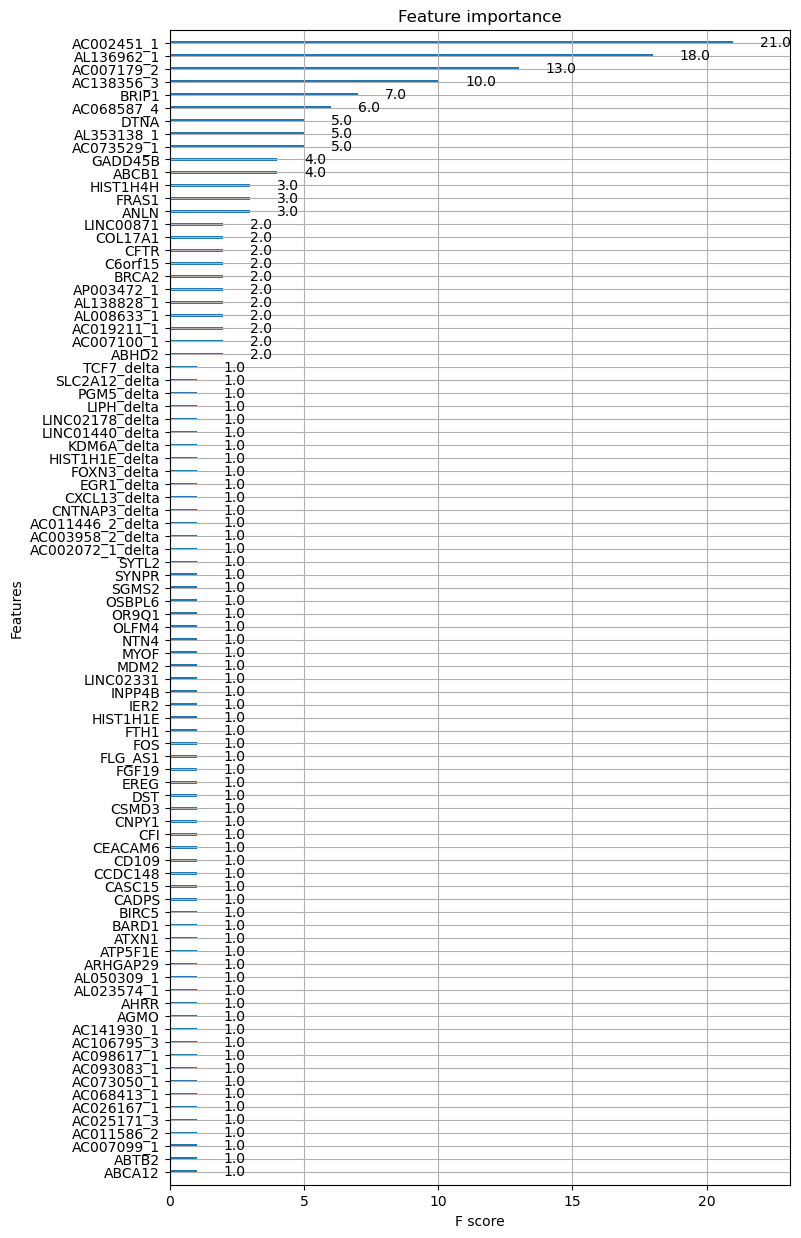

In [100]:
fig, ax = plt.subplots(figsize = (8, 15))
plot_importance(xgb_tuned, ax = ax)

In [101]:
predictions = xgb_tuned.predict(pivot_72_dropped)
accuracy = accuracy_score(y_72, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.33%


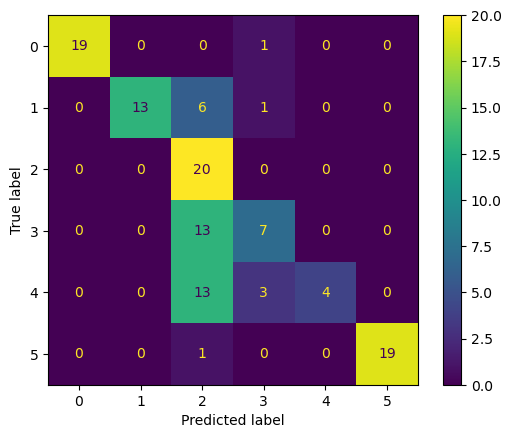

In [102]:
cm = confusion_matrix(y_72, predictions)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [34]:
corr_matrix = pivot_24.corr(method = 'pearson')
#corr_matrix = corr_matrix.pow(2)
corr_matrix = corr_matrix.stack()
corr_matrix = corr_matrix[((corr_matrix > 0.8)) & (corr_matrix != 1)]
corr_matrix = corr_matrix.to_frame()
corr_gene_list = np.unique(corr_matrix.index.get_level_values(0))
corr_matrix

0
ABAT         ASS1          0.821474
             ZBTB20        0.808042
AC002451_1   ASB4          0.814838
             XACT          0.823282
AC007100_1   NKD1          0.807462
...                             ...
WDPCP_delta  NKD1_delta    0.809414
WNK2_delta   FGF20_delta   0.801854
ZBTB20_delta NEAT1_delta   0.821800
             SYNE2_delta   0.804809
ZBTB7C_delta MT_ND5_delta  0.810607

[1188 rows x 1 columns]

In [96]:
random.shuffle(corr_gene_list)
for gene in corr_gene_list:
    for corr in corr_matrix[corr_matrix.index.get_level_values(0) == gene].index.get_level_values(1):
        if (random.randint(0, 1) == 0) & (corr in np.unique(corr_matrix.index.get_level_values(0))) & (gene in np.unique(corr_matrix.index.get_level_values(0))):
            corr_matrix.drop(labels = corr, axis = 0, inplace = True)
        if (random.randint(0, 1) == 1) & (gene in np.unique(corr_matrix.index.get_level_values(0))):
            corr_matrix.drop(labels = gene, axis = 0, inplace = True)

In [ ]:
accuracies = []

for threshold in [0.7]:
    for i in range(1, 21):
        corr_matrix = pivot_24.corr(method = 'pearson')
        #corr_matrix = corr_matrix.pow(2)
        corr_matrix = corr_matrix.stack()
        corr_matrix = corr_matrix[((corr_matrix > threshold)) & (corr_matrix != 1)]
        corr_matrix = corr_matrix.to_frame()
        corr_gene_list = np.unique(corr_matrix.index.get_level_values(0))
        random.shuffle(corr_gene_list)

        for gene in corr_gene_list:
            for corr in corr_matrix[corr_matrix.index.get_level_values(0) == gene].index.get_level_values(1):
                if (random.randint(0, 1) == 0) & (corr in np.unique(corr_matrix.index.get_level_values(0))) & (gene in np.unique(corr_matrix.index.get_level_values(0))):
                    corr_matrix.drop(labels = corr, axis = 0, inplace = True)
                if (random.randint(0, 1) == 1) & (gene in np.unique(corr_matrix.index.get_level_values(0))):
                    corr_matrix.drop(labels = gene, axis = 0, inplace = True)
        
        pivot_24_dropped = pivot_24.drop(labels = np.unique(corr_matrix.index.get_level_values(1)), axis = 1)
        pivot_48_dropped = pivot_48.drop(labels = np.unique(corr_matrix.index.get_level_values(1)), axis = 1)
        pivot_72_dropped = pivot_72.drop(labels = np.unique(corr_matrix.index.get_level_values(1)), axis = 1)

        xgb_tuned = XGBClassifier(learning_rate = 0.2,
                            max_depth = 16,
                            n_estimators = 460,
                            subsample = 0.3)
        xgb_tuned.fit(pivot_24_dropped, y_24)

        predictions = xgb_tuned.predict(pivot_72_dropped)
        accuracy = accuracy_score(y_72, predictions)

        print(f'Accuracy of attempt {i} at threshold {threshold}: {accuracy * 100}%')
        accuracies.append(accuracy * 100)

(array([1., 1., 1., 5., 2., 2., 1., 1., 1., 5.]),
 array([59.16666667, 60.75      , 62.33333333, 63.91666667, 65.5       ,
        67.08333333, 68.66666667, 70.25      , 71.83333333, 73.41666667,
        75.        ]),
 <BarContainer object of 10 artists>)

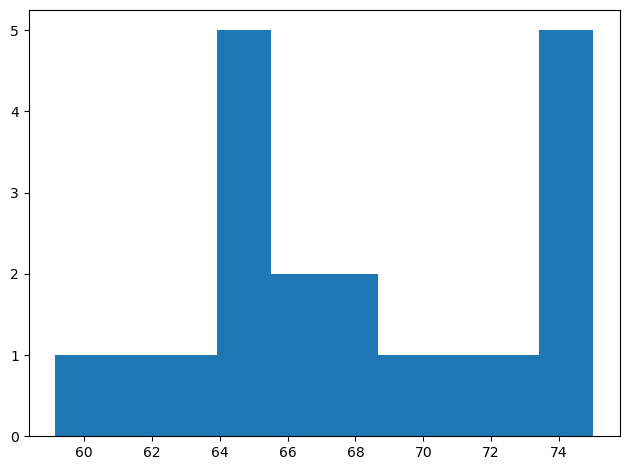

In [19]:
fig, axs = plt.subplots(1, sharey = True, tight_layout = True)
axs.hist(accuracies, bins = 10)

In [15]:
corr_matrix_72 = pivot_72.corr(method = 'pearson')
corr_matrix_72 = corr_matrix_72.stack()
corr_matrix_72 = corr_matrix_72[((corr_matrix_72 > 0.8)) & (corr_matrix_72 != 1)]
corr_matrix_72 = corr_matrix_72.to_frame()
corr_matrix_72

0
ABAT         ABTB2        0.802658
             AC011287_1   0.822771
             AREG         0.889117
             ARHGAP29     0.805510
             ASS1         0.801256
...                            ...
ZBTB20_delta GULP1_delta  0.826833
ZFPM2_delta  AC073050_1   0.817809
             PLB1         0.813292
             ZFPM2        0.883857
ZNF831_delta ZNF831       0.875959

[2450 rows x 1 columns]

In [35]:
covariates = []

for gene in results[:40]['columns']:
    if gene in results_24[:40]['columns'].values:
        covariates.append(gene)
    for corr in corr_matrix[corr_matrix.index.get_level_values(0) == gene].index.get_level_values(1):
        if corr in results_24[:40]['columns'].values:
            covariates.append(corr)
    for corr72 in corr_matrix_72[corr_matrix_72.index.get_level_values(0) == gene].index.get_level_values(1):
        if corr72 in results_24[:40]['columns'].values:
            covariates.append(corr72)

In [37]:
pivot_24_filter = pivot_24
pivot_48_filter = pivot_48
pivot_72_filter = pivot_72

for gene in np.unique(covariates):
    for corr in corr_matrix[corr_matrix.index.get_level_values(0) == gene].index.get_level_values(1):
        if corr in pivot_24_filter.columns:
            pivot_24_filter = pivot_24_filter.drop(labels = corr, axis = 1)
            pivot_48_filter = pivot_48_filter.drop(labels = corr, axis = 1)
            pivot_72_filter = pivot_72_filter.drop(labels = corr, axis = 1)

In [36]:
covariates

['AC007100_1',
 'AC007179_2',
 'C4orf51',
 'AC104823_1',
 'AC019211_1',
 'ABTB2',
 'ABTB2',
 'AC011287_1',
 'CXCL8',
 'AC099560_1',
 'ABHD2',
 'AC003958_2',
 'ABTB2']

In [172]:
pivot_24_test = pivot_24.drop(labels = corr_matrix[corr_matrix.index.get_level_values(0) == 'AC007179_2'].index.get_level_values(1), axis = 1)
pivot_72_test = pivot_72.drop(labels = corr_matrix[corr_matrix.index.get_level_values(0) == 'AC007179_2'].index.get_level_values(1), axis = 1)

In [38]:
for threshold in [0.8]:
    for i in range(1, 51):
        corr_matrix = pivot_24_filter.corr(method = 'pearson')
        #corr_matrix = corr_matrix.pow(2)
        corr_matrix = corr_matrix.stack()
        corr_matrix = corr_matrix[((corr_matrix > threshold)) & (corr_matrix != 1)]
        corr_matrix = corr_matrix.to_frame()
        corr_gene_list = np.unique(corr_matrix.index.get_level_values(0))
        random.shuffle(corr_gene_list)

        for gene in corr_gene_list:
            for corr in corr_matrix[corr_matrix.index.get_level_values(0) == gene].index.get_level_values(1):
                if (random.randint(0, 1) == 0) & (corr in np.unique(corr_matrix.index.get_level_values(0))) & (gene in np.unique(corr_matrix.index.get_level_values(0))):
                    corr_matrix.drop(labels = corr, axis = 0, inplace = True)
                if (random.randint(0, 1) == 1) & (gene in np.unique(corr_matrix.index.get_level_values(0))):
                    corr_matrix.drop(labels = gene, axis = 0, inplace = True)
        
        pivot_24_dropped = pivot_24_filter.drop(labels = np.unique(corr_matrix.index.get_level_values(1)), axis = 1)
        pivot_48_dropped = pivot_48_filter.drop(labels = np.unique(corr_matrix.index.get_level_values(1)), axis = 1)
        pivot_72_dropped = pivot_72_filter.drop(labels = np.unique(corr_matrix.index.get_level_values(1)), axis = 1)

        xgb_tuned = XGBClassifier(learning_rate = 0.2,
                            max_depth = 16,
                            n_estimators = 460,
                            subsample = 0.3)
        xgb_tuned.fit(pivot_24_dropped, y_24)

        predictions = xgb_tuned.predict(pivot_72_dropped)
        accuracy = accuracy_score(y_72, predictions)

        print(f'Accuracy of attempt {i} at threshold {threshold}: {accuracy * 100}%')

Accuracy of attempt 1 at threshold 0.8: 56.666666666666664%
Accuracy of attempt 2 at threshold 0.8: 72.5%
Accuracy of attempt 3 at threshold 0.8: 56.666666666666664%
Accuracy of attempt 4 at threshold 0.8: 66.66666666666666%
Accuracy of attempt 5 at threshold 0.8: 73.33333333333333%
Accuracy of attempt 6 at threshold 0.8: 72.5%
Accuracy of attempt 7 at threshold 0.8: 75.0%
Accuracy of attempt 8 at threshold 0.8: 57.49999999999999%
Accuracy of attempt 9 at threshold 0.8: 72.5%
Accuracy of attempt 10 at threshold 0.8: 66.66666666666666%
Accuracy of attempt 11 at threshold 0.8: 66.66666666666666%
Accuracy of attempt 12 at threshold 0.8: 72.5%
Accuracy of attempt 13 at threshold 0.8: 75.0%
Accuracy of attempt 14 at threshold 0.8: 72.5%
Accuracy of attempt 15 at threshold 0.8: 73.33333333333333%
Accuracy of attempt 16 at threshold 0.8: 73.33333333333333%
Accuracy of attempt 17 at threshold 0.8: 73.33333333333333%
Accuracy of attempt 18 at threshold 0.8: 64.16666666666667%
Accuracy of attemp

In [80]:
xgb_tuned = XGBClassifier(learning_rate = 0.2,
                            max_depth = 16,
                            n_estimators = 460,
                            subsample = 0.3)
xgb_tuned.fit(pivot_24, y_24)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=460, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [81]:
predictions = xgb_tuned.predict(pivot_72)
accuracy = accuracy_score(y_72, predictions)
print(accuracy * 100)

69.16666666666667
